In [36]:
import wandb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
import os
import yaml
import numpy as np
import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
from scipy.fft import irfft, rfft
import gc
import time
sys.path.append(os.path.abspath("../lab_scripts"))
from constellation_diagram import QPSK_Constellation
from constellation_diagram import RingShapedConstellation

if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ["junk"]
wandb.finish()
NUM_POINTS_FRAME = 6000
# NUM_POINTS_FRAME = 3040
CP_LENGTH = 2000
# CP_LENGTH = 1013
NUM_POINTS_SYMBOL = NUM_POINTS_FRAME + CP_LENGTH
POWER_NORMALIZATION = False

In [37]:
api = wandb.Api()
run = api.run("dylanbackprops-university-of-washington/mldrivenpeled/a43irtq9") # Variable
model_name = "channel_model_final"
artifact = api.artifact("dylanbackprops-university-of-washington/mldrivenpeled/channel_model:v1965") # Variable
artifact_dir = artifact.download()
remote_config = run.config
run_name = run.name
print("Channel Run name:", run_name)

wandb:   1 of 1 files downloaded.  


Channel Run name: stoic-leaf-7833


In [38]:
remote_config

{'Nf': 1499,
 'Nt': 1,
 'lr': 0.001,
 'flow': 300000,
 'gain': 20,
 'fhigh': '15e6',
 'epochs': 1,
 'nlayers': 2,
 'CP_ratio': 0.25,
 'fnyquist': '30e6',
 'gaussian': False,
 'lr_joint': '1e-3',
 'lr_noise': '1e-3',
 'num_taps': 10,
 'wd_joint': '1e-4',
 'wd_noise': '1e-3',
 'dc_offset': 3.5,
 'batch_size': 16,
 'lr_channel': '1e-3',
 'wd_channel': '1e-3',
 'learn_noise': True,
 'weight_init': 'default',
 'dilation_base': 2,
 'scheduler_type': 'reduce_lr_on_plateu',
 'hidden_channels': 8,
 'num_points_symbol': 4000,
 'training_schedule': [{'mode': 'channel_only', 'epochs': 10}],
 'subcarrier_spacing': '1e4',
 'num_symbols_per_frame': 1}

In [39]:
print("Contents of artifact_dir:", os.listdir(artifact_dir))
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps") # for M chip Macs
else:
    device = torch.device("cpu")
# device = torch.device("cpu")
print(device)

Contents of artifact_dir: ['channel_model_final.pth']
cuda


In [40]:
class ABC_time_model(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        if theta is None:
            self.theta = torch.nn.Parameter(torch.zeros(5))
        else:
            self.theta = theta
        self.last_n_traj = None


    def forward(self, x, return_n=True):
        # x: [B, T]
        B, T = x.shape
        device = x.device
        dtype = x.dtype
        n = torch.zeros(B, device=device, dtype=dtype)
        n_traj = torch.empty(B, T, device=device, dtype=dtype) if return_n else None
        outputs = torch.empty(B, T, device=device, dtype=dtype)
        theta0, theta1, theta2, theta3, theta4 = self.theta[0], self.theta[1], self.theta[2], self.theta[3], self.theta[4]
        for t in range(T):
            nsq = n * n
            n = (x[:, t] + theta0 * n + theta1 * nsq + theta2 * nsq * n)
            n = torch.tanh(n)
            outputs[:, t] = theta3 * n + theta4 * nsq
            assert not torch.isnan(n).any(), f"NaN detected at step {t}"
            if return_n:
                n_traj[:, t] = n
        self.last_n_traj = n_traj

        return outputs

class WarmupThenPlateau:
    """
    A learning rate scheduler that first performs a linear warmup for a given
    number of steps, and then hands over control to another scheduler (e.g., ReduceLROnPlateau).
    """
    def __init__(self, optimizer, warmup_steps, after_scheduler, target_lr):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.after_scheduler = after_scheduler
        self.step_num = 0
        self.target_lr = target_lr

    def step(self, metrics=None):
        self.step_num += 1

        if self.step_num <= self.warmup_steps:
            # During the warmup phase, linearly increase the learning rate.
            lr_scale = self.step_num / self.warmup_steps
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = lr_scale * self.target_lr
        else:
            # On the first step after warmup, ensure the LR is set to the base value.
            # This creates a clean handoff to the after_scheduler.
            if self.step_num == self.warmup_steps + 1:
                for i, param_group in enumerate(self.optimizer.param_groups):
                    param_group['lr'] = self.target_lr

            # After the warmup, let the after_scheduler manage the LR.
            self.after_scheduler.step(metrics)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.dtype = torch.float32

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return x

class TimeSymbolEmbedding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        # Input features: Real, Imag, Magnitude, Phase, Normalized Frequency Index
        self.linear = nn.Linear(2, d_model)
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, dropout=0, max_len=max_len)  # Create an instance

    def forward(self, x: torch.tensor) -> torch.tensor:
        # x shape: [Nt, 2Nf + 2, 2] (complex)
        x_power = x.square().unsqueeze(-1)
        x_combined = torch.cat([x.unsqueeze(-1), x_power], dim=-1)
        x = self.linear(x_combined) # [Nt, Nf, d_model]
        x = self.positional_encoding(x)
        return x # [Nt, Nf, d_model]


class PositionalEncoding(nn.Module):
    """Adds information about the position of each token in the sequence."""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Args: x: Tensor, shape [batch_size, seq_len, embedding_dim]"""
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TimeEmbedding(nn.Module):
    """Embeds a 1D time-series input to a d_model dimension."""
    def __init__(self, d_model: int):
        super().__init__()
        self.embed = nn.Linear(1, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embed(x)

class TimeTransformer(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 nlayers,
                 dim_feedforward,
                 dropout):
        super().__init__()
        self.symbol_embed = TimeSymbolEmbedding(d_model, max_len=NUM_POINTS_FRAME)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        self.output_unembed = nn.Linear(d_model, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.symbol_embed(x) # [Nt, 2Nf + 2, d_model]
        x = self.transformer(x)
        x = self.output_unembed(x).squeeze(-1) # [Nt, 2Nf + 2] linear map
        return x # [Nt, 2Nf + 2]


class RecursiveTransformer(nn.Module):
    def __init__(self,
                 taps,
                 d_model,
                 nhead,
                 dim_feedforward,
                 nlayers,
                 dropout):
        super().__init__()
        self.taps = taps
        self.time_embed = TimeEmbedding(d_model)
        self.pos_embed = PositionalEncoding(d_model, max_len=taps)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        self.output_unembed = nn.Linear(d_model, 1)


    def forward(self, x):
        # Pad input
        B, N = x.shape
        x_padded = F.pad(x, (self.taps - 1, 0))
        sliding_windows = x_padded.unfold(dimension=1, size=self.taps, step=1)
        sliding_windows_flat = sliding_windows.reshape(-1, self.taps)
        embedded_windows = self.time_embed(sliding_windows_flat.unsqueeze(-1))
        embedded_windows = self.pos_embed(embedded_windows)
        out_windows = self.transformer(embedded_windows)
        out = out_windows[:, -1, :] # [B, N, taps, dmodel] -> [B, N, dmodel]
        out = self.output_unembed(out) # [B, N, 1]
        out = out.reshape(B, N)
        out = out - out.mean(dim=1, keepdim=True) # Remove DC bias
        return out

class RecursiveStateTransformer(nn.Module):
    def __init__(self,
                 taps,
                 d_model,
                 nhead,
                 dim_feedforward,
                 nlayers,
                 dropout,
                 state_size=1):
        super().__init__()
        self.taps = taps
        self.time_embed = TimeEmbedding(d_model)
        self.pos_embed = PositionalEncoding(d_model, max_len=taps + state_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        self.output_unembed = nn.Linear(d_model, 1 + state_size)
        self.state_embed = nn.Linear(state_size, d_model)
        self.state_size = state_size

    def forward(self, x):
        B, N = x.shape
        device = x.device
        # Initialize the hidden state
        state = torch.zeros(B, self.state_size, device=device)
        outputs = []
        x_padded = F.pad(x, (self.taps - 1, 0))
        for t in range(N):
            window = x_padded[:, t:t+self.taps]
            embedded_window = self.time_embed(window.unsqueeze(-1)) # (B, taps, d_model)
            embedded_state = self.state_embed(state).unsqueeze(1) # (B, 1, d_model)
            transformer_input = torch.cat([embedded_window, embedded_state], dim=1) # (B, taps+1, d_model)
            positioned_input = self.pos_embed(transformer_input)
            transformer_out = self.transformer(positioned_input)
            feature_vector = transformer_out[:, -2, :] # (B, d_model)
            prediction_and_state = self.output_unembed(feature_vector)
            y_pred_t = prediction_and_state[:, 0]
            state = prediction_and_state[:, 1:]
            outputs.append(y_pred_t)
        out = torch.stack(outputs, dim=1)
        out -= torch.mean(out, dim=-1, keepdim=True) # Remove DC bias
        return torch.stack(outputs, dim=1)

class LearnableFrequencyNoise(nn.Module):
    def __init__(self, sequence_length: int):
        super().__init__()
        num_freq_bins = sequence_length // 2 + 1
        self.noise_psd = nn.Parameter(torch.zeros(num_freq_bins))

    def forward(self, x):
        batch_size, seq_len = x.shape
        noise_power = F.softplus(self.noise_psd)
        noise_amplitude = torch.sqrt(noise_power)
        noise_amplitude_batch = noise_amplitude.unsqueeze(0).expand(batch_size, -1)
        random_phase = torch.exp(1j * 2 * torch.pi * torch.rand_like(noise_amplitude_batch))
        noise_fft = noise_amplitude_batch * random_phase
        time_domain_noise = torch.fft.irfft(noise_fft, n=seq_len)
        return time_domain_noise

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=0
        )
        self.padding = (kernel_size - 1) * dilation
        self.relu = nn.ReLU()
        self.resample = None
        if in_channels != out_channels:
            self.resample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = F.pad(x, (self.padding, 0))
        out = self.conv(out)
        out = self.relu(out)
        if out.size(2) > x.size(2):
            out = out[:, :, :x.size(2)]
        if self.resample:
            x = self.resample(x)
        return out + x  # residual connection


def sample_student_t_mps(mean, std, nu):
    '''
    Wilson-Hilferty Approximation for chi^2 converted to scaled and shifted student t
    '''
    z = torch.randn_like(mean)
    z_chi = torch.randn_like(mean)
    chi2_approx = nu * (1 - 2/(9*nu) + z_chi * torch.sqrt(2/(9*nu))).pow(3)
    chi2_approx = chi2_approx.clamp(min=0.01)
    scale = torch.sqrt(nu / chi2_approx)
    return mean + std * z * scale



class TCN(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.readout = nn.Conv1d(hidden_channels, 1, kernel_size=1)

        # Calculate the total receptive field for the whole TCN stack
        self.receptive_field = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            self.receptive_field += (num_taps - 1) * dilation

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out).squeeze(1)
        out = out - out.mean(dim=1, keepdim=True)  # [B,T]
        return out


class TCN_channel(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10,
                 hidden_channels=32, learn_noise=False, gaussian=True):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.learn_noise = learn_noise
        self.tcn = nn.Sequential(*layers)
        if gaussian:
            self.readout = nn.Conv1d(hidden_channels, 2, kernel_size=1) # 2 channels mean | std
        else:
            self.readout = nn.Conv1d(hidden_channels, 3, kernel_size=1) # 3 channels mean | std | nu
        self.num_taps = num_taps
        self.gaussian = gaussian

        if not gaussian:
            with torch.no_grad():
                # Initialize nu bias towards Gaussian for stability
                self.readout.bias[2].fill_(48)

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out) # [B, 3, T] mean | std | nu
        mean_out = out[:, 0, :]
        log_std_out = out[:, 1, :]
        std_out = torch.exp(log_std_out)
        if not self.gaussian:
            log_nu_out = out[:, 2, :]
            nu_out = torch.nn.functional.softplus(log_nu_out)
            nu_out = torch.clamp(nu_out, 2, 50) # nu between 2 and 50
        mean_out = mean_out - mean_out.mean(dim=1, keepdim=True)  # [B ,T]

        # # Produce noisy output
        if self.gaussian:
            z = torch.randn_like(mean_out)
            noisy_out = mean_out + std_out * z
            nu_out = torch.zeros_like(mean_out)
        else:
            noisy_out = sample_student_t_mps(mean_out, std_out, nu_out)
            
        if self.learn_noise:
            return noisy_out, mean_out, std_out, nu_out
        else:
            return mean_out

In [41]:
# channel_model = RecursiveTransformer(
#         taps=remote_config['taps'],
#         d_model=remote_config['d_model'],
#         nhead=remote_config['nhead'],
#         nlayers=remote_config['nlayers'],
#         dim_feedforward=remote_config['dim_feedforward'],
#         dropout=remote_config['dropout']
# ).to(device)

channel_model = TCN_channel(
    nlayers=remote_config['nlayers'],
    dilation_base=remote_config['dilation_base'],
    num_taps=remote_config['num_taps'],
    hidden_channels=remote_config['hidden_channels'],
    learn_noise=remote_config['learn_noise'],
    gaussian=remote_config['gaussian']
).to(device)

# channel_model.learn_noise = False

channel_model_path = os.path.join(artifact_dir, model_name + ".pth")
checkpoint = torch.load(channel_model_path)
channel_model.load_state_dict(checkpoint["channel_model"])

# Freeze before moving to device
for param in channel_model.parameters():
    param.requires_grad = False

channel_model = channel_model.to(device).float()
channel_model.eval()

print("Channel model parameters frozen:",
      all(not param.requires_grad for param in channel_model.parameters()))

Channel model parameters frozen: True


C:\Users\maild\AppData\Local\Temp\ipykernel_26740\130712831.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(channel_model_path)


In [42]:
constellation_mode = "m7_apsk_constellation"

def get_constellation(mode: str):
        if mode == "qpsk":
            constellation = QPSK_Constellation()
        elif mode == "m5_apsk_constellation":
            constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m5_apsk_constellation.npy')
        elif mode == "m6_apsk_constellation":
             constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m6_apsk_constellation.npy')
        elif mode == "m7_apsk_constellation":
             constellation = RingShapedConstellation(filename=r'C:\Users\maild\mldrivenpeled\lab_scripts\saved_constellations\m7_apsk_constellation.npy')
        return constellation

constellation = get_constellation(constellation_mode)

In [43]:
script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "offline_time_ae_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

    wandb.init(project="mldrivenpeled",
            config=hyperparams,
            tags=['autoencoder'])
    config = wandb.config
    if wandb.run.notes is None:
        wandb.run.notes = ""
    config.modulator = constellation_mode
    wandb.run.notes += wandb.run.notes + f"\n | trained on channel model {run_name} \n | {constellation_mode}"
    print("WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

WandB run info:
  Name: hearty-galaxy-7834
  ID: f0enfdtj
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/f0enfdtj
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'dc_offset': 0, 'num_taps': 10, 'epochs': 1, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 16, 'dilation_base': 2, 'preamble_amplitude': 3, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'Nf': 370, 'Nt': 1, 'flow': 300000, 'fhigh': '4e6', 'subcarrier_spacing': '1e4', 'modulator': 'm7_apsk_constellation'}


In [44]:
# Create models
# encoder = RecursiveTransformer(taps=config.taps,
#                              d_model=config.d_model,
#                              nhead=config.nhead,
#                              nlayers=config.nlayers,
#                              dim_feedforward=config.dim_feedforward,
#                              dropout=config.dropout)

# decoder = RecursiveTransformer(taps=config.taps,
#                              d_model=config.d_model,
#                              nhead=config.nhead,
#                              nlayers=config.nlayers,
#                              dim_feedforward=config.dim_feedforward,
#                              dropout=config.dropout)


encoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
).to(device)

decoder = TCN(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels
).to(device)

In [45]:
optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=config.lr, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)

In [46]:
NUM_BITS = config.Nt * config.Nf * constellation.modulation_order
FREQUENCIES = torch.arange(float(config.flow), float(config.fhigh), float(config.subcarrier_spacing))
delta_f = FREQUENCIES[1] - FREQUENCIES[0]
KS = (FREQUENCIES / delta_f).to(torch.int)
K_MIN = int(KS[0].item())
K_MAX = int(KS[-1].item())
NUM_ZEROS = K_MIN - 1
UPSAMPLING_ZEROS= (NUM_POINTS_FRAME  +  -2 * K_MIN + -2 * len(KS)) // 2
PREAMBLE_MAX = config.preamble_amplitude
UPSAMPLING_ZEROS

2600

In [47]:
NUM_BITS

2590

In [48]:
def make_time_validate_plots(sent_frames_time, received_frames_time, decoded_frames_time,
                             frame_BER, run_model, step=0, zoom_samples=200):

    # Convert to numpy
    enc_in = sent_frames_time.detach().cpu().numpy().flatten()
    enc_out = received_frames_time.detach().cpu().numpy().flatten()
    dec_in = received_frames_time.detach().cpu().numpy().flatten()
    dec_out = decoded_frames_time.detach().cpu().numpy().flatten()

    # Power and scaling
    enc_power_in = np.mean(enc_in**2)
    enc_power_out = np.mean(enc_out**2)
    enc_scale = enc_power_out / (enc_power_in + 1e-12)

    dec_power_in = np.mean(dec_in**2)
    dec_power_out = np.mean(dec_out**2)
    dec_scale = dec_power_out / (dec_power_in + 1e-12)

    # MSEs
    mse_encoder = np.mean((enc_in - enc_out) ** 2)
    mse_decoder = np.mean((dec_in - dec_out) ** 2)
    mse_total = np.mean((enc_in - dec_out) ** 2)

    # Log scalars
    prefix = "time_"
    wandb.log({f"{prefix}mse_loss": mse_total}, step=step)
    wandb.log({f"{prefix}frame_BER": frame_BER}, step=step)

    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(12, 16))
    time_points = np.arange(zoom_samples)

    axes[0].plot(time_points, enc_in[:zoom_samples], 'r', alpha=0.5, label='Encoder Input')
    axes[0].plot(time_points, enc_out[:zoom_samples], 'b', alpha=0.8, label='Encoder Output')
    axes[0].set_title(
        f"Encoder Comparison (MSE: {mse_encoder:.2e}) | "
        f"In {enc_power_in:.3f} | Out {enc_power_out:.3f} | Scale {enc_scale:.3f}"
    )
    axes[0].legend(); axes[0].grid(True)

    axes[1].plot(time_points, dec_in[:zoom_samples], 'r', alpha=0.5, label='Decoder Input')
    axes[1].plot(time_points, dec_out[:zoom_samples], 'b', alpha=0.8, label='Decoder Output')
    axes[1].set_title(
        f"Decoder Comparison (MSE: {mse_decoder:.2e}) | "
        f"In {dec_power_in:.3f} | Out {dec_power_out:.3f} | Scale {dec_scale:.3f}"
    )
    axes[1].legend(); axes[1].grid(True)

    axes[2].plot(time_points, enc_in[:zoom_samples], 'r', alpha=0.5, label='Original Input')
    axes[2].plot(time_points, dec_out[:zoom_samples], 'b', alpha=0.8, label='Final Output')
    axes[2].set_title(
        f"End-to-End Comparison ({'Trained' if run_model else 'Untrained'})\n"
        f"MSE: {mse_total:.2e}, BER: {frame_BER:.2f}"
    )
    axes[2].legend(); axes[2].grid(True)

    fig.tight_layout()
    wandb.log({f"{prefix}time_signals": wandb.Image(fig)}, step=step)
    plt.close(fig)

In [49]:
CP_LENGTH

2000

In [50]:
KS

tensor([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 2

In [51]:
def evm_loss(true_symbols, predicted_symbols):
    return torch.mean(torch.abs(true_symbols - predicted_symbols) ** 2)

def in_band_filter(x, ks_indices, nfft):
    mask = torch.zeros(nfft, device=device)
    neg_ks_indices = nfft - ks_indices
    mask[ks_indices] = 1.0
    mask[neg_ks_indices] = 1.0

    impulse_response = torch.fft.ifftshift(torch.fft.ifft(mask).real)
    h = impulse_response.view(1, 1, -1)
    filtered_x = F.conv1d(x.unsqueeze(1), h, padding='same').squeeze(1)
    return filtered_x


def in_band_time_loss(sent_time, decoded_time, ks_indices, n_fft, num_taps):
    """Compute in-band loss directly in time domain using filtering"""
    # Create frequency mask
    mask = torch.zeros(n_fft, device=sent_time.device)
    neg_ks_indices = n_fft - ks_indices
    mask[ks_indices] = 1.0
    mask[neg_ks_indices] = 1.0

    # Convert to time-domain filter (this is differentiable)
    impulse_response = torch.fft.ifftshift(torch.fft.ifft(mask).real)
    h = impulse_response.view(1, 1, -1)

    # Filter both signals
    sent_filtered = F.conv1d(sent_time.unsqueeze(1), h, padding='same').squeeze(1)
    decoded_filtered = F.conv1d(decoded_time.unsqueeze(1), h, padding='same').squeeze(1)

    # Compute MSE on filtered signals (equivalent to in-band frequency loss)
    loss = torch.mean((sent_filtered[:, num_taps:] - decoded_filtered[:, num_taps:]).pow(2))
    return loss


def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0):
    # Make hermetian symmetric
    Nt, Nf = X.shape
    padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
    leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
    X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
    DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
    X_hermitian = torch.flip(X, dims=[1]).conj()
    X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])
    # Convert to time domain
    x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
    return x_time.to(device)

def add_noise(signal, SNR):
    signal_power = signal.abs().pow(2).mean()
    noise_power = signal_power / SNR
    noise_std = (noise_power / 2) ** 0.5 # real and complex
    noise = noise_std * torch.randn_like(signal) + noise_std * 1j * torch.randn_like(signal)
    signal += noise
    return signal

# def add_noise_time(signal, SNR):
#     signal_power = signal.pow(2).mean()
#     noise_power = signal_power / SNR
#     noise_std = noise_power.sqrt()
#     noise = noise_std * torch.randn_like(signal)
#     return signal + noise


def add_noise_time_cp(signal_with_cp, cp_length, snr_in, snr_low, snr_high, inband_idx, print_snr=False):
    """
    Adds spectrally-shaped noise with three regions:
      - In-band: indices in inband_idx
      - Low out-of-band: below min(inband_idx)
      - High out-of-band: above max(inband_idx)
    """
    B, N_with_cp = signal_with_cp.shape
    device = signal_with_cp.device

    signal_no_cp = signal_with_cp[:, cp_length:]
    P_sig = signal_no_cp.pow(2).mean(dim=-1, keepdim=True)

    Pn_in_target = P_sig / snr_in
    Pn_low_target = P_sig / snr_low
    Pn_high_target = P_sig / snr_high

    num_pos_freqs = (N_with_cp - 1) // 2
    pos_freq_slice = slice(1, num_pos_freqs + 1)
    neg_freq_slice = slice(N_with_cp - num_pos_freqs, N_with_cp)

    inband_mask = torch.zeros(num_pos_freqs, dtype=bool, device=device)
    valid_inband_indices = inband_idx[(inband_idx > 0) & (inband_idx <= num_pos_freqs)]
    if valid_inband_indices.numel() > 0:
        inband_mask[valid_inband_indices - 1] = True

    all_idx = torch.arange(num_pos_freqs, device=device)
    low_mask = (all_idx < inband_idx.min()) & ~inband_mask
    high_mask = (all_idx > inband_idx.max()) & ~inband_mask

    num_in_bins = inband_mask.sum()
    num_low_bins = low_mask.sum()
    num_high_bins = high_mask.sum()

    def make_noise(num_bins, target_power):
        if num_bins == 0:
            return torch.zeros((B, 0), dtype=torch.complex64, device=device)
        var_per_bin = (target_power * N_with_cp) / (2 * num_bins)
        std_per_bin = torch.sqrt(var_per_bin)
        noise = (torch.randn(B, num_bins, device=device) +
                 1j * torch.randn(B, num_bins, device=device)) / math.sqrt(2.0)
        return std_per_bin * noise

    noise_in_pos = make_noise(num_in_bins, Pn_in_target)
    noise_low_pos = make_noise(num_low_bins, Pn_low_target)
    noise_high_pos = make_noise(num_high_bins, Pn_high_target)

    noise_pos = torch.zeros(B, num_pos_freqs, dtype=torch.complex64, device=device)
    if num_in_bins > 0: noise_pos[:, inband_mask] = noise_in_pos
    if num_low_bins > 0: noise_pos[:, low_mask] = noise_low_pos
    if num_high_bins > 0: noise_pos[:, high_mask] = noise_high_pos

    noise_fft = torch.zeros(B, N_with_cp, dtype=torch.complex64, device=device)
    noise_fft[:, pos_freq_slice] = noise_pos
    noise_fft[:, neg_freq_slice] = torch.conj(torch.flip(noise_pos, dims=[1]))
    noise_fft[:, 0] = 0
    noise_time = torch.fft.ifft(noise_fft, norm="ortho").real

    if print_snr:
        P_sig_mean = P_sig.mean().item()
        def check(mask, noise_vals, target):
            if mask.sum() == 0: return
            tmp_fft = torch.zeros_like(noise_fft)
            tmp_pos = torch.zeros_like(noise_pos); tmp_pos[:, mask] = noise_vals
            tmp_fft[:, pos_freq_slice] = tmp_pos
            tmp_fft[:, neg_freq_slice] = torch.conj(torch.flip(tmp_pos, dims=[1]))
            Pn_actual = torch.fft.ifft(tmp_fft, norm="ortho").real.pow(2).mean().item()
            print(f"SNR Check: target={target:.2f}, actual={P_sig_mean/Pn_actual:.2f}")
        check(inband_mask, noise_in_pos, snr_in)
        check(low_mask, noise_low_pos, snr_low)
        check(high_mask, noise_high_pos, snr_high)

    return signal_with_cp + noise_time



def calculate_BER(received_symbols, true_bits, constellation):
    # Demap symbols to bits
    constellation_symbols = torch.tensor(
        list(constellation._symbols_to_bits_map.keys()),
        dtype=received_symbols.dtype,
        device=received_symbols.device
    )
    distances = abs(received_symbols.reshape(-1, 1) - constellation_symbols.reshape(1, -1))

    closest_idx = distances.argmin(axis=1)
    constellation_symbols_list = list(constellation._symbols_to_bits_map.keys())
    decided_bits = [constellation._symbols_to_bits_map[constellation_symbols_list[idx]] for idx in closest_idx.cpu().numpy()]

    # Flatten decided bits into a 1D array
    decided_bits_flat = [int(bit) for symbol_bits in decided_bits for bit in symbol_bits]


    # Convert to NumPy arrays for comparison
    true_bits_array = np.array(true_bits)
    decided_bits_flat_array = np.array(decided_bits_flat)

    # Take minimum length to avoid shape mismatch
    min_len = min(len(true_bits_array), len(decided_bits_flat_array))
    true_bits_array = true_bits_array[:min_len]
    decided_bits_flat_array = decided_bits_flat_array[:min_len]

    # Calculate BER
    BER = float(np.sum(true_bits_array != decided_bits_flat_array) / len(true_bits_array))
    return BER


def train(encoder, decoder, optimizer, scheduler, config, device, mask=None):

    encoder = encoder.to(device)
    decoder = decoder.to(device)

    for epoch in range(config["epochs"]):
        encoder.train()
        decoder.train()

        epoch_loss = 0
        epoch_freq_loss = 0
        optimizer.zero_grad()
        batch_entries = []
        true_bits_list = []
        for batch in range(config["batch_size"]):
            # Generate frame data
            true_bits = np.random.randint(0, 2, size=NUM_BITS)
            true_bits_list.append(torch.tensor(true_bits))
            # true_bits = np.zeros(NUM_BITS).astype(int)
            true_bits_str = ''.join(map(str, true_bits))
            true_symbols = torch.tensor(
                constellation.bits_to_symbols(true_bits_str),
                dtype=torch.complex64, device=device
            )
            true_frame = true_symbols.reshape(config["Nt"], config["Nf"])

            # Add known experimental noise

            # true_frame = torch.zeros(config["Nt"], config["Nf"])
            # true_frame[:, 100] = 10

            if POWER_NORMALIZATION:
                true_frame = true_frame / true_frame.abs().pow(2).mean(dim=1, keepdim=True).sqrt()
            batch_entries.append(true_frame)

        true_bits = torch.stack(true_bits_list)

        # Batch along time domain
        true_frame = torch.cat(batch_entries)

        # print("Inband symbol power", true_frame.abs().square().mean())
        # Convert to time domain
        sent_frames_time = symbols_to_time(true_frame, UPSAMPLING_ZEROS, NUM_ZEROS)
        sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))

        encoded_frames_time = encoder(sent_frames_time)
        # encoded_frames_time = in_band_filter(encoded_frames_time, KS, NUM_POINTS_FRAME)

        # Clip to preamble make
        encoded_frames_time = torch.clip(encoded_frames_time, -PREAMBLE_MAX, PREAMBLE_MAX)
        # encoded_frames_time = add_noise_time_cp(encoded_frames_time,
        #                                              snr_in=float(100000),
        #                                                 snr_low=float(100000),
        #                                                snr_high=0,
        #                                               inband_idx=torch.arange(int(1), int(25e6)),
        #                                              cp_length=CP_LENGTH)

        received_frames_time, mean, std, nu = channel_model(encoded_frames_time)


        # Filter out of band noise
        # received_frames_time_noisy = in_band_filter(received_frames_time_noisy, KS, NUM_POINTS_FRAME)

        # received_frames_time = add_noise(received_frames_time, SNR=10**(config["snr_db"]/10))
        decoded_frames_time = decoder(received_frames_time)

        # Convert to frequency domain for loss
        sent_frames_frequency = torch.tensor(rfft(sent_frames_time[:, CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])
        decoded_frames_frequency = torch.tensor(rfft(decoded_frames_time[:, CP_LENGTH:].detach().cpu().numpy(), norm='ortho', axis=1)[:, KS])

        sent_norm = sent_frames_frequency.abs().square().mean(dim=1, keepdim=True).sqrt()
        decoded_norm = decoded_frames_frequency.abs().square().mean(dim=1, keepdim=True).sqrt()


        if POWER_NORMALIZATION:
            sent_frames_frequency = sent_frames_frequency / sent_norm
            decoded_frames_frequency = decoded_frames_frequency / decoded_norm


        # print("Time power through channel", sent_frames_time.abs().square().mean().item(), received_frames_time.abs().square().mean().item(), sent_frames_time.shape)
        loss = in_band_time_loss(sent_frames_time, decoded_frames_time, ks_indices=KS, n_fft=NUM_POINTS_FRAME, num_taps=config['num_taps'])
        # loss = evm_loss(sent_frames_time, decoded_frames_time)
        diff_complex = sent_frames_frequency.detach() - decoded_frames_frequency.detach()
        # print("evm shapes", sent_frames_frequency.shape, decoded_frames_frequency.shape)
        freq_loss = torch.mean(diff_complex.abs().pow(2))

        loss.backward()
        epoch_loss += loss.item()
        epoch_freq_loss += freq_loss.item()


        optimizer.step()
        scheduler.step(epoch_loss)

        wandb.log({"loss": epoch_loss}, step=epoch)
        wandb.log({"freq_loss": epoch_freq_loss}, step=epoch)
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr}, step=epoch)

        # Get BER
        ber = calculate_BER(decoded_frames_frequency.detach().flatten(), true_bits.flatten(), constellation=constellation)
        wandb.log({"BER": ber}, step=epoch)

        if epoch % 5 == 0:
            make_time_validate_plots(
            sent_frames_time[0],
            received_frames_time[0],
            decoded_frames_time[0],
            frame_BER=ber,
            run_model=True,
            step=epoch
            )

            # Plot first example of sent and reconstructed time
            fig, ax = plt.subplots()
            ax.plot(sent_frames_time[0][:100].detach().cpu().numpy(), label="Sent (time)")
            ax.plot(decoded_frames_time[0][:100].detach().cpu().numpy(), label="Decoded (time)")
            ax.legend()
            ax.set_title(f"Sent vs Decoded (Time Domain) EVM: {loss: 0.3e}")
            wandb.log({"time_domain_plot": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            sent_symbols = sent_frames_frequency[0].detach().cpu().numpy()
            decoded_symbols = decoded_frames_frequency[0].detach().cpu().numpy()

            # Compute EVM for logging (per frame)
            evm_val = evm_loss(torch.tensor(sent_symbols), torch.tensor(decoded_symbols)).item()

            # Create constellation plot
            fig, ax = plt.subplots()
            ax.scatter(sent_symbols.real, sent_symbols.imag, color='blue', alpha=0.6, label='Sent')
            ax.scatter(decoded_symbols.real, decoded_symbols.imag, color='red', alpha=0.6, label='Decoded')
            ax.set_xlabel('In-phase')
            ax.set_ylabel('Quadrature')
            ax.set_title(f'Constellation Diagram EVM: {evm_val:0.3e}')
            ax.legend()
            ax.grid(True)

            # Log to wandb
            wandb.log({"constellation": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            evm_per_freq = ((sent_frames_frequency[0] - decoded_frames_frequency[0]).abs()**2).detach().cpu().numpy()
            fig, ax = plt.subplots()
            ax.plot(evm_per_freq)
            ax.set_title("EVM vs Frequency")
            wandb.log({"evm_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)


            # Plot Model SNRs
            sent_k = torch.fft.fft(encoded_frames_time[:, CP_LENGTH:], norm="ortho", dim=-1)
            received_k = torch.fft.fft(mean[:, CP_LENGTH:], norm="ortho", dim=-1)

            residual = received_frames_time - mean
            received_noise_k = torch.fft.fft(residual[:, CP_LENGTH:] ** 2, norm="ortho", dim=-1)


            signal_power = torch.mean(torch.abs(sent_k) ** 2, dim=0).detach().cpu().numpy()
            received_power = torch.mean(torch.abs(received_k) ** 2, dim=0).detach().cpu().numpy()
            received_noise_power = torch.mean(torch.abs(received_noise_k), dim=0).detach().cpu().numpy()
            snr_vs_freq = (received_power / received_noise_power + 1e-12)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(signal_power[:len(signal_power)//2]))
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            ax.set_title(f"Encoded Signal Frequency Power Spectrum for {run.name}")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            wandb.log({"encoded_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(received_power[:len(received_power)//2]))
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            ax.set_title(f"Received Signal Frequency Power Spectrum for {run.name}")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            wandb.log({"received_signal_power_spectrum": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(snr_vs_freq[:len(snr_vs_freq)//2]))
            ax.set_title(f"SNR vs Freq Estimate for {run.name}")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("SNR (dB)")
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            wandb.log({"snr_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

            fig, ax = plt.subplots()
            ax.plot(10 * np.log10(received_noise_power[:len(snr_vs_freq)//2]))
            ax.set_title(f"Noise power vs Freq Estimate for {run.name}")
            ax.set_xlabel("Freq Index k (10 kHz)")
            ax.set_ylabel("Power (dB)")
            ax.axvline(30, c='r', linestyle='--')
            ax.axvline(int(4e2), c='r', linestyle='--')
            wandb.log({"noise_power_vs_freq": wandb.Image(fig)}, step=epoch)
            plt.close(fig)

    # Save model
    torch.save({
        "time_encoder": encoder.state_dict(),
        "time_decoder": decoder.state_dict()
    }, "time_autoencoder.pth")

    artifact = wandb.Artifact("time_autoencoder", type="model")
    artifact.add_file("time_autoencoder.pth")
    wandb.log_artifact(artifact)

    return epoch_loss

train(encoder, decoder, optimizer, scheduler, config, device)
wandb.finish()

C:\Users\maild\AppData\Local\Temp\ipykernel_26740\2692998263.py:160: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  true_bits_array = np.array(true_bits)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


BER,▁
freq_loss,▁
learning_rate,▁
loss,▁
time_frame_BER,▁
time_mse_loss,▁
BER,0.49959
freq_loss,0.99699
learning_rate,0.001
loss,0.12293
time_frame_BER,0.49959


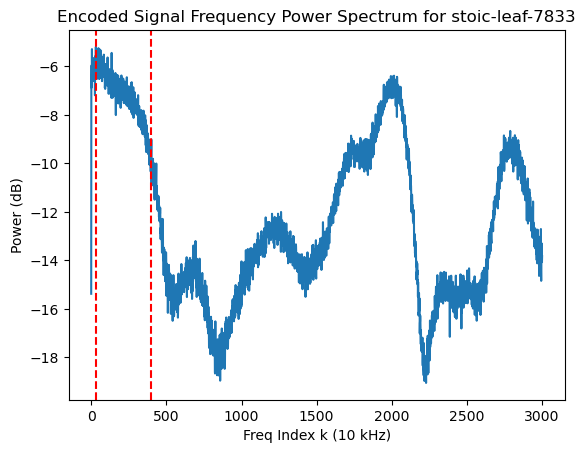

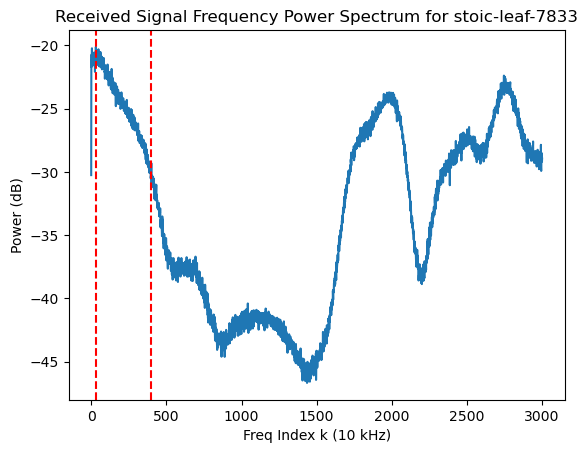

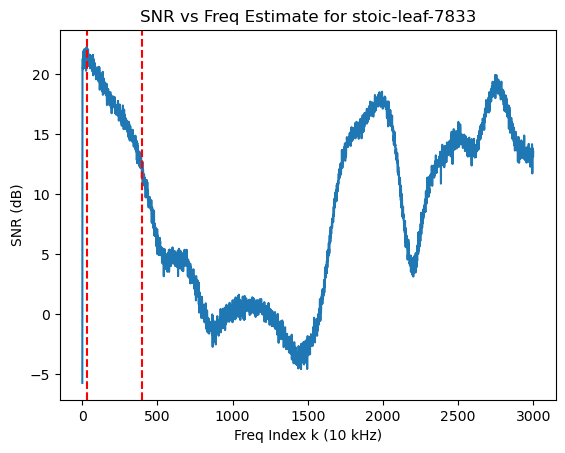

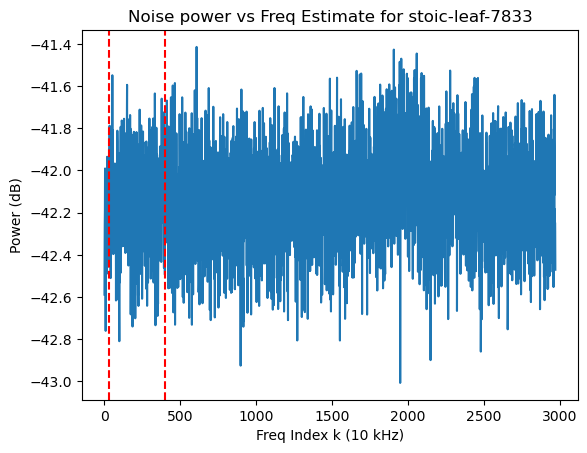

In [52]:
# Get SNR vs freq estimate
test_freqs = torch.arange(0, 1e4 * 2999, 1e4, device=device)
test_ks = (test_freqs / (1e4)).to(torch.int)
true_bits = np.random.randint(0, 2, size=7 * len(test_freqs) * 100)


true_bits_str = ''.join(map(str, true_bits))
true_symbols = torch.tensor(
    constellation.bits_to_symbols(true_bits_str),
    dtype=torch.complex64, device=device
)

test = (NUM_POINTS_FRAME  +  -2 * test_ks[0] + -2 * len(test_ks)) // 2

true_frame = true_symbols.reshape(100, 2999)
true_bits = torch.tensor(true_bits)
sent_frames_time = symbols_to_time(true_frame, test, 0)
sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))
encoded_frames_time = encoder(sent_frames_time)
received_frames_time_noisy, mean, std, nu = channel_model(encoded_frames_time)
decoded_frames_time = decoder(received_frames_time_noisy)

sent_k = torch.fft.fft(encoded_frames_time[:, CP_LENGTH:], norm="ortho", dim=-1)
received_k = torch.fft.fft(mean[:, CP_LENGTH:], norm="ortho", dim=-1)

residual = received_frames_time_noisy - mean
received_noise_k = torch.fft.fft(residual[:, CP_LENGTH:] ** 2, norm="ortho", dim=-1)


signal_power = torch.mean(torch.abs(sent_k) ** 2, dim=0).detach().cpu().numpy()
received_power = torch.mean(torch.abs(received_k) ** 2, dim=0).detach().cpu().numpy()
received_noise_power = torch.mean(torch.abs(received_noise_k), dim=0).detach().cpu().numpy()
snr_vs_freq = (received_power / received_noise_power + 1e-12)


plt.plot(10 * np.log10(signal_power[:len(signal_power)//2]))
plt.axvline(30, c='r', linestyle='--')
plt.axvline(int(4e2), c='r', linestyle='--')
plt.title(f"Encoded Signal Frequency Power Spectrum for {run.name}")
plt.xlabel("Freq Index k (10 kHz)")
plt.ylabel("Power (dB)")
plt.show()

plt.plot(10 * np.log10(received_power[:len(received_power)//2]))
plt.axvline(30, c='r', linestyle='--')
plt.axvline(int(4e2), c='r', linestyle='--')
plt.title(f"Received Signal Frequency Power Spectrum for {run.name}")
plt.xlabel("Freq Index k (10 kHz)")
plt.ylabel("Power (dB)")
plt.show()


plt.plot(10 * np.log10(snr_vs_freq[:len(snr_vs_freq)//2]))
plt.title(f"SNR vs Freq Estimate for {run.name}")
plt.xlabel("Freq Index k (10 kHz)")
plt.ylabel("SNR (dB)")
plt.axvline(30, c='r', linestyle='--')
plt.axvline(int(4e2), c='r', linestyle='--')
plt.show()


plt.plot(10 * np.log10(received_noise_power[30:len(snr_vs_freq)//2]))
plt.title(f"Noise power vs Freq Estimate for {run.name}")
plt.xlabel("Freq Index k (10 kHz)")
plt.ylabel("Power (dB)")
plt.axvline(30, c='r', linestyle='--')
plt.axvline(int(4e2), c='r', linestyle='--')
plt.show()

In [53]:
def objective(trial, tag):
    # Sample hyperparameters
    dilation_base = trial.suggest_categorical("dilation_base", [2])
    num_taps = trial.suggest_int("num_taps", 10, 30, step=2)
    hidden_channels = trial.suggest_int("hidden_channels", 4, 64, step=8)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    nlayers = trial.suggest_categorical("nlayers", [2, 3, 4])

    local_config = {
        "dilation_base": dilation_base,
        "num_taps": num_taps,
        "hidden_channels": hidden_channels,
        "lr": lr,
        "epochs": 800,
        "batch_size": 16,
        "Nt": 1,
        "Nf": 370,
        "save_path": "./saved_models",
        "nlayers": nlayers,
        "weight_init": "default",
        "scheduler_type": "reduce_lr_on_plateu",
        "modulator": f"{constellation_mode}"
    }

    wandb.init(project="mldrivenpeled", config=local_config, reinit=True,
               tags=['autoencoder', f'{tag}', f'trial {trial.number}'], mode='online')

    wandb.run.notes = f"\n | trained on channel model {run_name} \n | {constellation_mode}"

    encoder = None
    decoder = None
    optimizer = None
    scheduler = None

    try:
        encoder = TCN(
            nlayers=nlayers,
            dilation_base=dilation_base,
            num_taps=num_taps,
            hidden_channels=hidden_channels
        ).to(device)

        decoder = TCN(
            nlayers=nlayers,
            dilation_base=dilation_base,
            num_taps=num_taps,
            hidden_channels=hidden_channels
        ).to(device)

        optimizer = torch.optim.Adam(
            list(encoder.parameters()) + list(decoder.parameters()), lr=lr
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        final_loss = train(encoder, decoder, optimizer, scheduler, local_config, device)

        return final_loss

    finally:
        wandb.finish()
        time.sleep(0.5)

        del encoder, decoder, optimizer, scheduler

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
study_name = f"optuna_offline_ae_model_{timestamp}"
# study_name= "optuna_offline_ae_model_20250919_174002"
study = optuna.create_study(direction="minimize", study_name=study_name, storage="sqlite:///optuna_results.db", load_if_exists=True)
study.optimize(lambda trial: objective(trial, study_name), n_trials=100)
print("Best trial:")
print(study.best_trial.params)

'''
{'dilation_base': 2, 'num_taps': 12, 'hidden_channels': 20, 'lr': 0.0005269745303114973, 'nlayers': 4, 'taps': 20} Current best with loss 2e-3
Trial 44 finished with value: 0.001965869450941682 and parameters: {'dilation_base': 2, 'num_taps': 10, 'hidden_channels': 44, 'lr': 0.009314226151764216, 'nlayers': 4}. Best is trial 44 with value: 0.001965869450941682
'''

[I 2025-12-05 16:32:56,214] A new study created in RDB with name: optuna_offline_ae_model_20251205_163256
c:\Users\maild\miniconda3\envs\mldrivenpeled\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [4, 64] and step=8, but the range is not divisible by `step`. It will be replaced by [4, 60].
  warnings.warn(
C:\Users\maild\AppData\Local\Temp\ipykernel_26740\4017121335.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)


C:\Users\maild\AppData\Local\Temp\ipykernel_26740\2692998263.py:160: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  true_bits_array = np.array(true_bits)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


BER,██████████▇▇▇▇▇▅▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
freq_loss,███▇▇▅▅▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,███▇▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time_frame_BER,███▇▇▅▄▃▂▂▁▁▁▁
time_mse_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁
BER,0.03342
freq_loss,0.00532
learning_rate,0.00028
loss,0.00067
time_frame_BER,0.03342


In [ ]:
storage = "sqlite:///optuna_results.db"
summaries = optuna.get_all_study_summaries(storage=storage)
for summary in summaries:
    print(f"Study name: {summary.study_name}")
    print(f"  Trial count: {summary.n_trials}")
    if summary.best_trial is not None:
        print(f"  Best value: {summary.best_trial.value}")
        print(f"  Best params: {summary.best_trial.params}")
    else:
        print("  No trials completed yet.")
    print("-" * 50)

In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)

# Step 1: Choose your study name (copy it from the summaries you printed earlier)
study_name = "optuna_offline_ae_model_20250928_115643"
storage = "sqlite:///optuna_results.db"

# Step 2: Load the study
study = optuna.load_study(study_name=study_name, storage=storage)

# Step 3: Plot using interactive Plotly charts
plot_optimization_history(study).show()
plot_param_importances(study).show()
plot_slice(study).show()
plot_parallel_coordinate(study).show()

In [ ]:
study.best_value

In [ ]:
study.best_trial

In [ ]:
study.best_params